In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
import keras.backend as K

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from aparent.data.aparent_data_plasmid_legacy import load_data

from analyze_aparent_conv_layers_helpers import *


Using TensorFlow backend.


In [49]:
#Load random MPRA data

file_path = '../data/random_mpra_legacy/combined_library/processed_data_lifted/'
plasmid_gens = load_data(batch_size=32, valid_set_size=1000, test_set_size=60000, kept_libraries=[20], file_path=file_path)


Training set size = 541450
Validation set size = 1000
Test set size = 60000


In [50]:
#Re-shuffle test set index

plasmid_index = np.arange(len(plasmid_gens['all'].sources['df']), dtype=np.int)
np.random.shuffle(plasmid_index)

plasmid_gens['test'].data_ids = plasmid_index[:60000]


In [51]:
#Load legacy APARENT model (lifted from theano)

model_name = 'aparent_theano_legacy_30_31_34'#_pasaligned

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

In [52]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion
conv_layer_iso_model = Model(
    inputs = aparent_model.inputs,
    outputs = [
        aparent_model.get_layer('iso_conv_layer_1').output,
        aparent_model.get_layer('iso_out_layer_1').output
    ]
)

In [53]:
#Predict from test data generator
iso_conv_1_out, iso_pred = conv_layer_iso_model.predict_generator(plasmid_gens['test'], workers=4, use_multiprocessing=True)

iso_conv_1_out = np.reshape(iso_conv_1_out, (iso_conv_1_out.shape[0], iso_conv_1_out.shape[1], iso_conv_1_out.shape[2]))

iso_pred = np.ravel(iso_pred[:, 1])

#Retrieve one-hot input sequences
onehot_seqs = np.concatenate([plasmid_gens['test'][i][0][0][:, 0, :, :] for i in range(len(plasmid_gens['test']))], axis=0)


In [54]:
#Mask for doubledope library (Alien1)
mask_seq = ('X' * (25 - 1 - 7)) + ('N' * (71 + 7)) + ('X' * (14 - 7)) + ('N' * (71 + 7 - 2))

for j in range(len(mask_seq)) :
    if mask_seq[j] == 'X' :
        iso_conv_1_out[:, :, j] = 0


In [55]:
#Layer 1: Compute Scaled Activation PWMs
filter_width = 8
pseudo_count = 1.0

pwms = np.zeros((iso_conv_1_out.shape[1], filter_width, 4))

for k in range(iso_conv_1_out.shape[1]) :
    
    for i in range(iso_conv_1_out.shape[0]) :
        max_j = np.argmax(iso_conv_1_out[i, k, :])
        if iso_conv_1_out[i, k, max_j] > 0 :
            pwms[k, :, :] += onehot_seqs[i, max_j: max_j+filter_width, :] * iso_conv_1_out[i, k, max_j]#np.exp(iso_conv_1_out[i, k, max_j])
    
    pwms[k, :, :] += pseudo_count
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)


In [56]:
def plot_pwm_logo(pwm, figsize=(6, 4)) :
    f = plt.figure(figsize=figsize)
    
    #Make sequence logo
    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    height_base = 0.0
    logo_height = 1.0
    
    logo_ax = plt.gca()
    
    for j in range(pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, logo_ax, color=None)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, logo_ax, color=None)

    plt.xlim((0, pwm.shape[0]))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    logo_ax.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)
    
    plt.tight_layout()
    plt.show()


def get_nmers(n_mer_len) :

    if n_mer_len == 0 :
        return []

    if n_mer_len == 1 :
        return ['A', 'C', 'G', 'T']

    n_mers = []

    prev_n_mers = get_nmers(n_mer_len - 1)

    for _, prev_n_mer in enumerate(prev_n_mers) :
        for _, nt in enumerate(['A', 'C', 'G', 'T']) :
            n_mers.append(prev_n_mer + nt)

    return n_mers

def plot_pwm_logprob_motifs(pwm, n=10, seq_start=0, seq_end=8, figsize=(4, 8)) :
    pwm = pwm[seq_start:seq_end, :]
    
    #Get nmers
    nmers = np.array(get_nmers(pwm.shape[0]), dtype=np.object)
    
    #Score nmers
    nmer_scores = np.zeros(nmers.shape[0])
    for i in range(nmers.shape[0]) :
        score = 0
        nmer = nmers[i]
        for j in range(len(nmer)) :
            if nmer[j] == 'A' :
                score += np.log(pwm[j, 0])
            elif nmer[j] == 'C' :
                score += np.log(pwm[j, 1])
            elif nmer[j] == 'G' :
                score += np.log(pwm[j, 2])
            elif nmer[j] == 'T' :
                score += np.log(pwm[j, 3])
        nmer_scores[i] = score
    
    #Sort scores and pick top selection
    sort_index = np.argsort(nmer_scores)[::-1][:n]
    nmers = nmers[sort_index]
    nmer_scores = nmer_scores[sort_index]
    
    f = plt.figure(figsize=figsize)
    
    plt.imshow(nmer_scores.reshape(-1, 1), cmap='Reds', vmin=np.min(nmer_scores), vmax=np.max(nmer_scores))
    plt.xticks([], [])
    plt.yticks(np.arange(nmer_scores.shape[0]), [nmer + ' ' + str(round(score, 2)) for nmer, score in zip(nmers, nmer_scores)], fontsize=14)
    
    plt.tight_layout()
    plt.show()
    


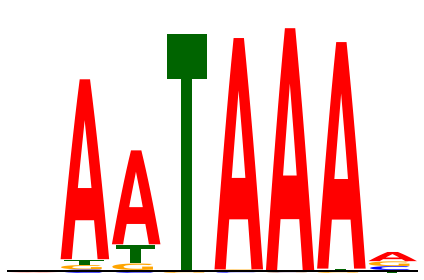

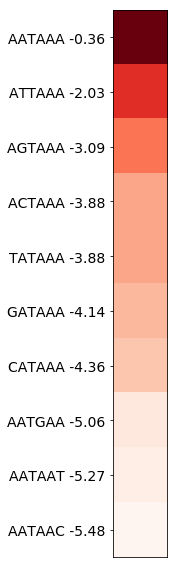

In [57]:
#Plot Scaled Activation PWM of CSE Hexamer filter (Filter 6, as identified in the Max Activation PWM script)

plot_pwm_logo(pwms[6], figsize=(6, 4))

plot_pwm_logprob_motifs(pwms[6], n=10, seq_start=1, seq_end=7, figsize=(4, 8))
